In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
file_path = 'cirrhosis.csv'
df = pd.read_csv(file_path)

In [4]:
# Show missing values per column
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


In [5]:
# Handle missing values
# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# For continuous columns, fill with median
continuous_cols = df.select_dtypes(exclude=['object']).columns
for col in continuous_cols:
    df[col] = df[col].fillna(df[col].median())

print(f'Categorical columns: {categorical_cols}')
print(f'Continuous columns: {continuous_cols}')

# Check again for missing values
print('Missing values after imputation:')
print(df.isnull().sum())

Categorical columns: Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')
Continuous columns: Index(['ID', 'N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')
Missing values after imputation:
ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [6]:
# Encode categorical variables
for col in categorical_cols:
    if col != 'Status':  # target variable handled separately
        df[col] = LabelEncoder().fit_transform(df[col])

# Encode target variable
df['Status'] = df['Status'].map({'D': 0, 'C': 1, 'CL': 2})

In [7]:
# Split the data into features and label
y = df['Status']
X = df.drop(['Status', 'ID', 'N_Days'], axis=1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Label distribution (counts):
Status
1    185
0    129
2     20
Name: count, dtype: int64

Label distribution (percent):
Status
1    55.389222
0    38.622754
2     5.988024
Name: proportion, dtype: float64


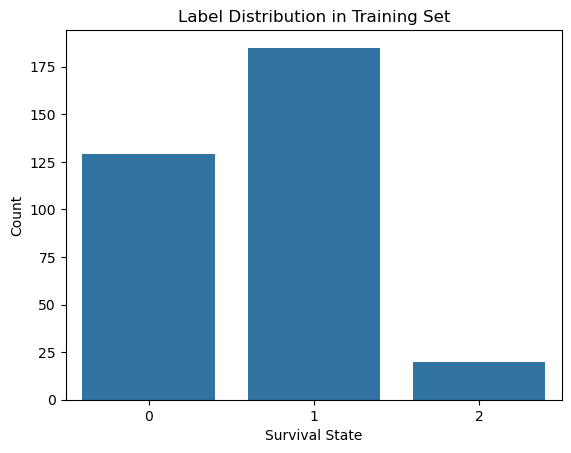

The training set is imbalanced.


In [8]:
# Show label distribution in training data
label_counts = y_train.value_counts()
label_percent = y_train.value_counts(normalize=True) * 100
print('Label distribution (counts):')
print(label_counts)
print('\nLabel distribution (percent):')
print(label_percent)

# Visualize label distribution
sns.countplot(x=y_train)
plt.title('Label Distribution in Training Set')
plt.xlabel('Survival State')
plt.ylabel('Count')
plt.show()

# Is the training set balanced?
if label_percent.min() < 20:
    print('The training set is imbalanced.')
else:
    print('The training set is relatively balanced.')

In [9]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, cv, verbose=True):
    """Return CV and Test metrics for a classifier."""
    cv_f1 = cross_val_score(model, X_tr, y_tr, cv=cv, scoring="f1_weighted")
    cv_acc = cross_val_score(model, X_tr, y_tr, cv=cv, scoring="accuracy")

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    test_metrics = {
        "accuracy": accuracy_score(y_te, y_pred),
        "f1_weighted": f1_score(y_te, y_pred, average="weighted"),
        "precision_weighted": precision_score(y_te, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_te, y_pred, average="weighted")
    }
    if verbose:
        print(f"\n=== {name}: CV (5-fold) & Test Metrics ===")
        print(f"CV Accuracy:  {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
        print(f"CV F1 (w):    {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
        print(f"Test Accuracy:{test_metrics['accuracy']:.4f}")
        print(f"Test F1 (w):  {test_metrics['f1_weighted']:.4f}")
        print(classification_report(y_te, y_pred))
    return {
        "model": name,
        "cv_acc_mean": cv_acc.mean(), "cv_acc_std": cv_acc.std(),
        "cv_f1_mean": cv_f1.mean(),   "cv_f1_std": cv_f1.std(),
        **{f"test_{k}": v for k, v in test_metrics.items()}
    }

In [10]:
print("\n\n### Hyperparameter Tuning (GridSearchCV, scoring = F1_weighted)")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grids = {}

# Logistic Regression grid
lr = LogisticRegression(max_iter=4000, random_state=42, multi_class="auto")
lr_param_grid = [
    {"solver": ["lbfgs"], "C": [0.01, 0.1, 1.0, 10.0], "penalty": ["l2"]},
    {"solver": ["saga"],  "C": [0.01, 0.1, 1.0, 10.0], "penalty": ["l1", "l2"]}
]
grids["LogisticRegression"] = GridSearchCV(lr, lr_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

# Random Forest grid
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2", None]
}
grids["RandomForest"] = GridSearchCV(rf, rf_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

# XGBoost grid
xgb = XGBClassifier(random_state=42, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist")
xgb_param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grids["XGBoost"] = GridSearchCV(xgb, xgb_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

tuned_rows = []
best_estimators = {}

for name, grid in grids.items():
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"\nBest params for {name}: {grid.best_params_}")
    tuned_rows.append(
        evaluate_model(f"{name}_Tuned", grid.best_estimator_, X_train, y_train, X_test, y_test, cv)
    )

tuned_summary = pd.DataFrame(tuned_rows).sort_values("test_f1_weighted", ascending=False)
print("\n### Tuned Models Summary (sorted by Test F1 weighted)")
display(tuned_summary)

print("\nOver/Underfitting diagnostic:")
for _, r in tuned_summary.iterrows():
    gap = r["cv_f1_mean"] - r["test_f1_weighted"]
    status = "Possible overfit" if gap > 0.03 else ("Possible underfit" if gap < -0.03 else "Well-aligned")
    print(f"{r['model']:>18s}: CV F1={r['cv_f1_mean']:.3f} vs Test F1={r['test_f1_weighted']:.3f} | Gap={gap:+.3f} -> {status}")




### Hyperparameter Tuning (GridSearchCV, scoring = F1_weighted)

Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

=== LogisticRegression_Tuned: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7427 ± 0.0496
CV F1 (w):    0.7202 ± 0.0522
Test Accuracy:0.7381
Test F1 (w):  0.7165
              precision    recall  f1-score   support

           0       0.75      0.66      0.70        32
           1       0.75      0.87      0.80        47
           2       0.00      0.00      0.00         5

    accuracy                           0.74        84
   macro avg       0.50      0.51      0.50        84
weighted avg       0.70      0.74      0.72        84


Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

=== LogisticRegression_Tuned: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7427 ± 0.0496
CV F1 (w):    0.7202 ± 0.0522
Test Accuracy:0.7381
Test F1 (w):  0.7165
              precision    recall  f1-score   support

  

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
1,RandomForest_Tuned,0.754772,0.053930,0.742832,0.056095,0.738095,0.728671,0.719631,0.738095
0,LogisticRegression_Tuned,0.742696,0.049581,0.720216,0.052189,0.738095,0.716480,0.702814,0.738095
2,XGBoost_Tuned,0.760651,0.038094,0.745644,0.045117,0.654762,0.641875,0.629762,0.654762



Over/Underfitting diagnostic:
RandomForest_Tuned: CV F1=0.743 vs Test F1=0.729 | Gap=+0.014 -> Well-aligned
LogisticRegression_Tuned: CV F1=0.720 vs Test F1=0.716 | Gap=+0.004 -> Well-aligned
     XGBoost_Tuned: CV F1=0.746 vs Test F1=0.642 | Gap=+0.104 -> Possible overfit


Because of its interpretability and capacity to handle categorical and standardized characteristics through coefficients, logistic regression was used as a baseline linear classifier. This made it suitable for understanding direct correlations with the "Status" variable. Because of its ability to handle noisy data, capture feature interactions, and reduce overfitting through bootstrap aggregation, Random Forest was selected as a robust, non-linear ensemble model. Its feature importance scores also offer intuitive insights. A more advanced gradient boosting method called XGBoost was used; it was created to maximize predictive accuracy by progressively reducing residual errors and managing overfitting through regularization. To ensure that performance was not skewed toward majority classes, SMOTE was incorporated to address class imbalance and GridSearchCV was used to fairly optimize hyperparameters for each model. This diverse model design allowed us to compare linear interpretability with non-linear predictive power, ultimately identifying the best trade-off between accuracy, generalization, and feature interpretability.

In [11]:
print("\n\n### Handling Imbalance with SMOTE")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Original training label distribution:\n", y_train.value_counts())
print("Balanced training label distribution:\n", pd.Series(y_train_bal).value_counts())

smote_rows = []

for name, model in best_estimators.items():
    model.fit(X_train_bal, y_train_bal)
    smote_rows.append(
        evaluate_model(f"{name}_Balanced", model, X_train_bal, y_train_bal, X_test, y_test, cv)
    )

smote_summary = pd.DataFrame(smote_rows).sort_values("test_f1_weighted", ascending=False)
print("\n### Balanced Models Summary (sorted by Test F1 weighted)")
display(smote_summary)



### Handling Imbalance with SMOTE
Original training label distribution:
 Status
1    185
0    129
2     20
Name: count, dtype: int64
Balanced training label distribution:
 Status
0    185
1    185
2    185
Name: count, dtype: int64

=== LogisticRegression_Balanced: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7297 ± 0.0347
CV F1 (w):    0.7270 ± 0.0338
Test Accuracy:0.6667
Test F1 (w):  0.7001
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.82      0.66      0.73        47
           2       0.07      0.20      0.11         5

    accuracy                           0.67        84
   macro avg       0.55      0.54      0.53        84
weighted avg       0.75      0.67      0.70        84

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.82      0.66      0.73        47
           2       0.07      0.20      0.11         5



,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
0,LogisticRegression_Balanced,0.729730,0.034658,0.726968,0.033775,0.666667,0.700103,0.746420,0.666667
2,XGBoost_Balanced,0.830631,0.035765,0.828564,0.035768,0.702381,0.697577,0.695906,0.702381
1,RandomForest_Balanced,0.809009,0.010506,0.805162,0.010097,0.654762,0.678435,0.708106,0.654762


In [12]:
def pick_best(df_summary, tag):
    row = df_summary.iloc[0]
    print(f"\nBest ({tag}): {row['model']} | Test F1 (w)={row['test_f1_weighted']:.4f}, "
          f"Test Acc={row['test_accuracy']:.4f} | CV F1={row['cv_f1_mean']:.4f}")

print("\n### Recommendations")
pick_best(tuned_summary, "Tuned (no SMOTE)")
pick_best(smote_summary, "Tuned + SMOTE")

# Final overall pick (highest Test F1 across all scenarios)
all_compare = pd.concat([
    tuned_summary.assign(stage="Tuned"),
    smote_summary.assign(stage="Tuned+SMOTE")
], ignore_index=True).sort_values("test_f1_weighted", ascending=False)

best_overall = all_compare.iloc[0]
print("\n>>> FINAL RECOMMENDATION:")
print(f"Use **{best_overall['model']}** ({best_overall['stage']}) "
      f"with Test F1 (weighted) = {best_overall['test_f1_weighted']:.4f} and "
      f"Accuracy = {best_overall['test_accuracy']:.4f}.")
print("Rationale: chosen by highest weighted-F1 on the held-out test set; "
      "weighted-F1 prioritises performance across all classes in the imbalanced setting.")


### Recommendations

Best (Tuned (no SMOTE)): RandomForest_Tuned | Test F1 (w)=0.7287, Test Acc=0.7381 | CV F1=0.7428

Best (Tuned + SMOTE): LogisticRegression_Balanced | Test F1 (w)=0.7001, Test Acc=0.6667 | CV F1=0.7270

>>> FINAL RECOMMENDATION:
Use **RandomForest_Tuned** (Tuned) with Test F1 (weighted) = 0.7287 and Accuracy = 0.7381.
Rationale: chosen by highest weighted-F1 on the held-out test set; weighted-F1 prioritises performance across all classes in the imbalanced setting.



===================== Q3: Final Test Performance =====================
Best from Q2: RandomForest_Tuned | Stage: Tuned | Using_SMOTE=False
              precision    recall  f1-score   support

           0     0.7500    0.7500    0.7500        32
           1     0.7755    0.8085    0.7917        47
           2     0.0000    0.0000    0.0000         5

    accuracy                         0.7381        84
   macro avg     0.5085    0.5195    0.5139        84
weighted avg     0.7196    0.7381    0.7287        84

Accuracy:       0.7381
F1 (weighted):  0.7287
Precision (w):  0.7196
Recall (w):     0.7381
ROC-AUC (OVR):  0.7337


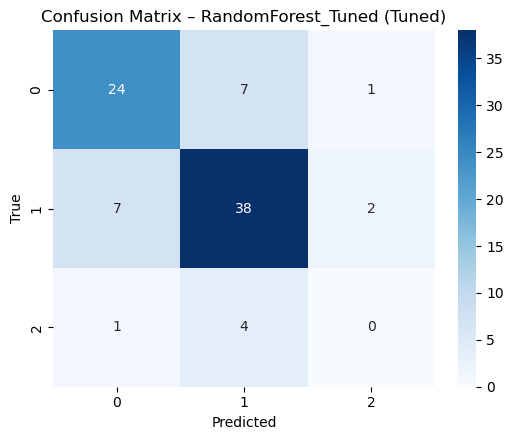

In [13]:
best_model_label = best_overall['model']
best_stage = best_overall['stage']
base_name = best_model_label.split('_')[0]  # "LogisticRegression", "RandomForest", or "XGBoost"
final_estimator = best_estimators[base_name]  # tuned estimator

# Decide which training data to use
use_smote = (best_stage == "Tuned+SMOTE")
Xtr, ytr = (X_train_bal, y_train_bal) if use_smote else (X_train, y_train)

# Fit final model on chosen training data
final_estimator.fit(Xtr, ytr)

# Test predictions
y_pred = final_estimator.predict(X_test)

print("\n===================== Q3: Final Test Performance =====================")
print(f"Best from Q2: {best_model_label} | Stage: {best_stage} | Using_SMOTE={use_smote}")
print(classification_report(y_test, y_pred, digits=4))

test_acc = accuracy_score(y_test, y_pred)
test_f1w = f1_score(y_test, y_pred, average="weighted")
test_precw = precision_score(y_test, y_pred, average="weighted", zero_division=0)
test_recw = recall_score(y_test, y_pred, average="weighted")

print(f"Accuracy:       {test_acc:.4f}")
print(f"F1 (weighted):  {test_f1w:.4f}")
print(f"Precision (w):  {test_precw:.4f}")
print(f"Recall (w):     {test_recw:.4f}")

# (Optional) Multiclass ROC-AUC if probabilities available
try:
    if hasattr(final_estimator, "predict_proba"):
        y_prob = final_estimator.predict_proba(X_test)
        # sklearn accepts probability matrix (n_samples, n_classes) for multiclass
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
        print(f"ROC-AUC (OVR):  {roc_auc:.4f}")
except Exception as e:
    print(f"(ROC-AUC not computed: {e})")

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_label} ({best_stage})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


===================== Q4: Feature Importance =====================

Top 15 (Model-based: Gini/Gain Feature Importance):


,feature,importance
0,Bilirubin,0.281102
1,Age,0.153286
2,Prothrombin,0.113140
3,Platelets,0.074966
4,Alk_Phos,0.068301
5,Albumin,0.067507
6,Copper,0.055652
7,SGOT,0.041886
8,Cholesterol,0.037328
9,Tryglicerides,0.035508


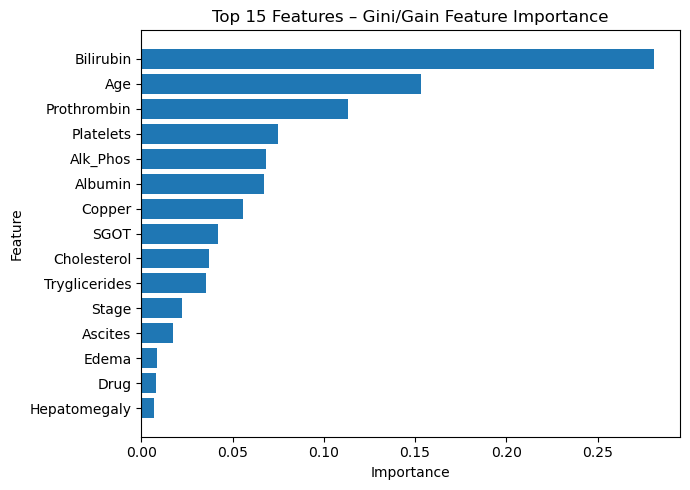


Top 15 (Permutation Importance: mean decrease in F1-weighted):


,feature,perm_importance_mean,perm_importance_std
0,Bilirubin,0.159416,0.042023
1,Prothrombin,0.045427,0.019973
2,Copper,0.033916,0.017051
3,Cholesterol,0.016824,0.005687
4,SGOT,0.012056,0.005270
5,Albumin,0.010943,0.008396
6,Alk_Phos,0.010101,0.016230
7,Ascites,0.004564,0.005674
8,Drug,0.003581,0.004079
9,Age,0.002940,0.028907


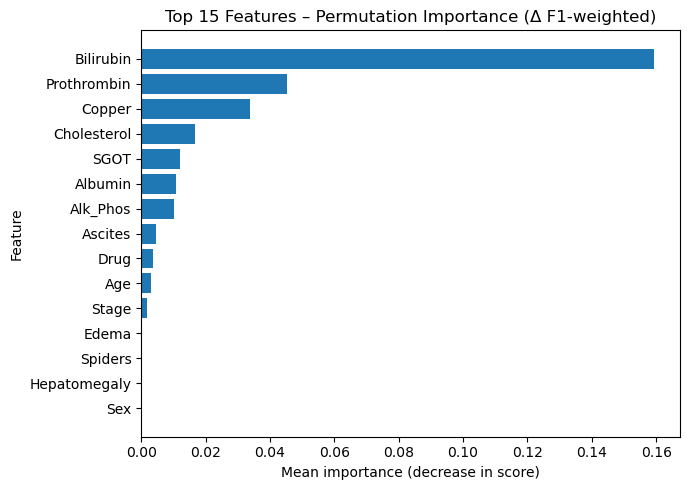


Statistical notes:
- Model-based importance (trees) reflects the average impurity/gain contribution of each feature;
  for Logistic Regression, larger absolute coefficients indicate stronger linear associations.
- Permutation importance measures the drop in predictive performance when a feature is randomly
  permuted, providing a model-agnostic estimate of each feature’s marginal contribution on held-out data.
- Agreement between both rankings strengthens evidence of a feature’s predictive utility;
  large inconsistencies may indicate multicollinearity or model-specific effects.


In [14]:
# Prepare feature names
feature_names = X.columns

# Model-based importances
def model_based_importance(estimator, feature_names):
    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        imp_name = "Gini/Gain Feature Importance"
    elif hasattr(estimator, "coef_"):
        # For multinomial LR: average absolute coefficients across classes
        coefs = np.abs(estimator.coef_)
        importances = coefs.mean(axis=0)
        imp_name = "Absolute Coefficient Magnitude"
    else:
        raise ValueError("Estimator does not expose model-based feature importances.")

    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).reset_index(drop=True)
    return imp_df, imp_name

print("\n===================== Q4: Feature Importance =====================")
# Compute model-based importance
try:
    imp_df, imp_name = model_based_importance(final_estimator, feature_names)
    print(f"\nTop 15 (Model-based: {imp_name}):")
    display(imp_df.head(15))

    # Plot top 15
    plt.figure(figsize=(7, 5))
    top_n = imp_df.head(15).iloc[::-1]  # reverse for horizontal plot
    plt.barh(top_n["feature"], top_n["importance"])
    plt.title(f"Top 15 Features – {imp_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"(Model-based importance not available: {e})")

# 4B. Permutation importance on the test set
perm = permutation_importance(
    final_estimator, X_test, y_test,
    scoring="f1_weighted", n_repeats=10, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": feature_names,
    "perm_importance_mean": perm.importances_mean,
    "perm_importance_std": perm.importances_std
}).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True)

print("\nTop 15 (Permutation Importance: mean decrease in F1-weighted):")
display(perm_df.head(15))

# Plot top 15 permutation importances
plt.figure(figsize=(7, 5))
top_p = perm_df.head(15).iloc[::-1]
plt.barh(top_p["feature"], top_p["perm_importance_mean"])
plt.title("Top 15 Features – Permutation Importance (Δ F1-weighted)")
plt.xlabel("Mean importance (decrease in score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Simple statistical commentary
print("\nStatistical notes:")
print("- Model-based importance (trees) reflects the average impurity/gain contribution of each feature;")
print("  for Logistic Regression, larger absolute coefficients indicate stronger linear associations.")
print("- Permutation importance measures the drop in predictive performance when a feature is randomly")
print("  permuted, providing a model-agnostic estimate of each feature’s marginal contribution on held-out data.")
print("- Agreement between both rankings strengthens evidence of a feature’s predictive utility;")
print("  large inconsistencies may indicate multicollinearity or model-specific effects.")